In [2]:
__author__ = "me"
__date__ = "2015_10_13"
%pylab inline

import pandas as pd
import numpy as np
# import geopandas as gp

import pylab as plt
import os

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)

from palettable.wesanderson import FantasticFox1_5
PARQA = os.getenv('PARQA')

Populating the interactive namespace from numpy and matplotlib


/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
calls = pd.read_csv(PARQA +'/parqa/311/TIMESERIES/311_timeseries.csv').set_index('parkDistrict')

In [4]:
pipTs = pd.read_csv(PARQA + '/parqa/311/TIMESERIES/PIP_score_timeseries.csv', index_col=0)


In [5]:
calls.head(2)

,2010,2011,2012,2013,2014,2015
parkDistrict,,,,,,
B-01,363,353,374,397,564,619
B-02,339,396,282,463,566,614


In [6]:
pip = pipTs[pipTs.score_type == 'Amenities & Area Normalized Score'][['District']+ [str(x) for x in xrange(2010,2016)]]
pip = pip.rename(columns={'District':'parkDistrict'}).set_index('parkDistrict')

pip.head(2)

,2010,2011,2012,2013,2014,2015
parkDistrict,,,,,,
B-01,0.809202,0.825962,0.831345,0.823218,0.854233,0.824545
B-02,0.839114,0.879936,0.895369,0.888944,0.887673,0.873778


In [7]:
def normalise_timeseries(df, label='parkDistrict', ax=1):
    '''normalise timeseries by row seeing everything 
       but label as part of it'''
    
    cols_to_norm = [x for x in df.columns if x!=label ]
    df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.std()), axis=ax)

    return df
    

In [8]:
pip_n = normalise_timeseries(pip)
calls_n = normalise_timeseries(calls)

In [9]:
calls_n.head(2)

,2010,2011,2012,2013,2014,2015
parkDistrict,,,,,,
B-01,-0.708531,-0.794937,-0.613484,-0.414750,1.028234,1.503468
B-02,-0.806317,-0.365805,-1.246828,0.151989,0.948002,1.318959


In [10]:
pip_n.head(2)

,2010,2011,2012,2013,2014,2015
parkDistrict,,,,,,
B-01,-1.277902,-0.143619,0.220666,-0.329300,1.769697,-0.239543
B-02,-1.895588,0.121915,0.884665,0.567136,0.504305,-0.182434


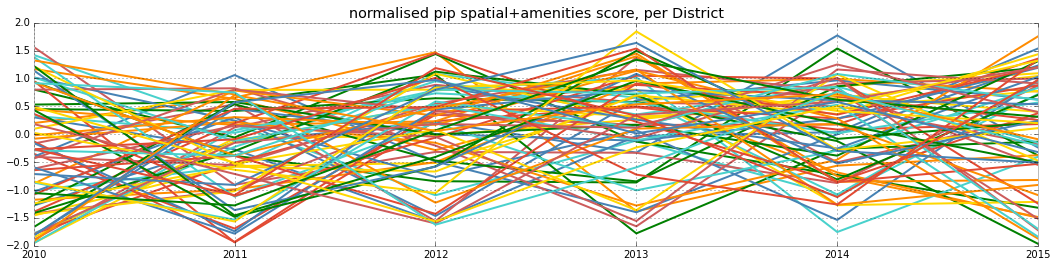

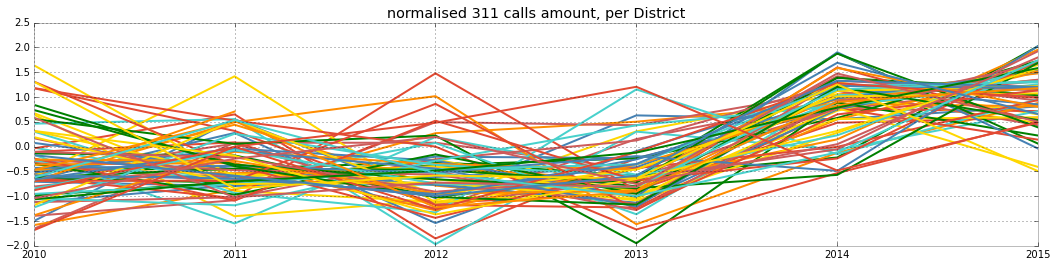

In [11]:
pip_n.T.plot(legend=0, figsize=(18,4), title='normalised pip spatial+amenities score, per District')
calls_n.T.plot(legend=0, figsize=(18,4), title='normalised 311 calls amount, per District')

------------------

## Checking correlation
**thinking logically there should be a negative corellation, but...**

In [9]:
corr = calls_n.corrwith(pip_n, axis=1)

In [10]:
def plotCorr(series, title='title'):
    fig, ax = plt.subplots(figsize=(10,10))
    series.sort_values(ascending=0).plot(kind='barh', figsize=(18,18), color='k', xticks=np.arange(-1,1.1,0.2), ax=ax, xlim=(-1,1));
    ax.set_title(title, fontsize=18)

    ax.plot([-.8, -.8], [0, 100], color='r', linestyle='--', linewidth=.6,  label='-0.8') ## -.8
    ax.plot([.8, .8], [0, 100], color='r', linestyle='--', linewidth=.6,  label='0.8') ## .8
    ax.plot([0, 0], [0, 100], color='r', linestyle='-', linewidth=1,  label='0.8'); ## 0

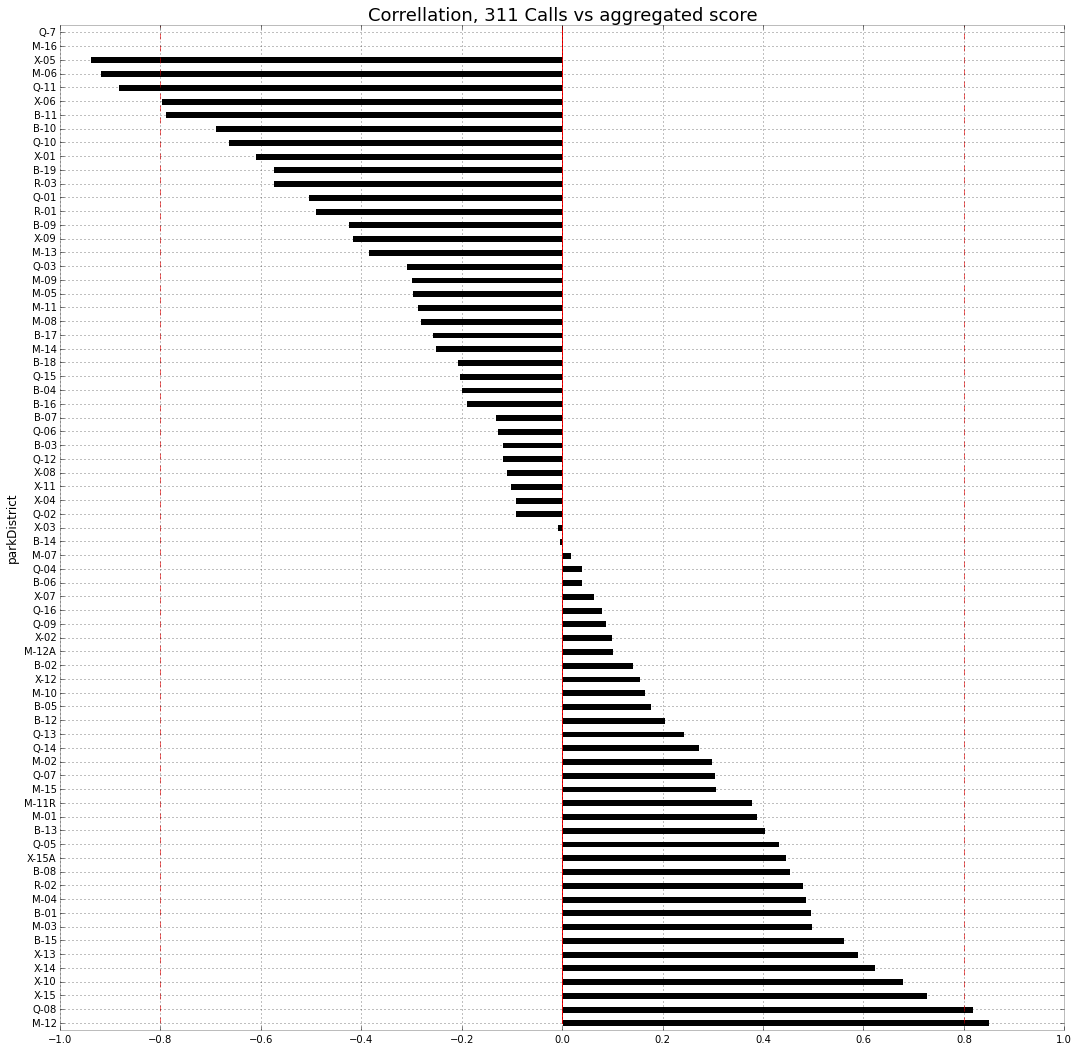

In [43]:
plotCorr(corr,title='Correllation, 311 Calls vs aggregated score' )

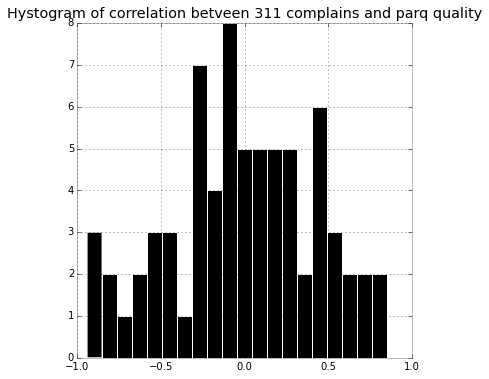

In [44]:
corr.hist(color='k',bins=20, figsize=(6,6))
plt.title('Hystogram of correlation betveen 311 complains and parq quality');

### Hight Positive corellation

In [47]:
corr[corr>.8]

parkDistrict
M-12    0.849086
Q-08    0.818821
dtype: float64

### Hight Negative corellation

In [17]:
corr[corr<-.8]

parkDistrict
M-06   -0.920382
Q-11   -0.883573
X-05   -0.941101
dtype: float64

In [18]:
corr.mean()

-0.018497436427292274

In [19]:
# here I tried to see histogram for each borough, but it wasn't that informative

# corrDF = pd.DataFrame(corr).reset_index().rename(columns={0:'Corr'})
# corrDF['Boro'] = corrDF.parkDistrict
# corrDF.Boro = corrDF.Boro.str.split('-').str.get(0)

## Checking correlation versus only Maitenance calls

In [20]:
mcalls = pd.read_csv(PARQA +'/parqa/311/TIMESERIES/311_timeseries_maintenance.csv').set_index('parkDistrict')
mcalls_n = normalise_timeseries(mcalls)

In [21]:
mcorr = mcalls_n.corrwith(pip_n, axis=1)

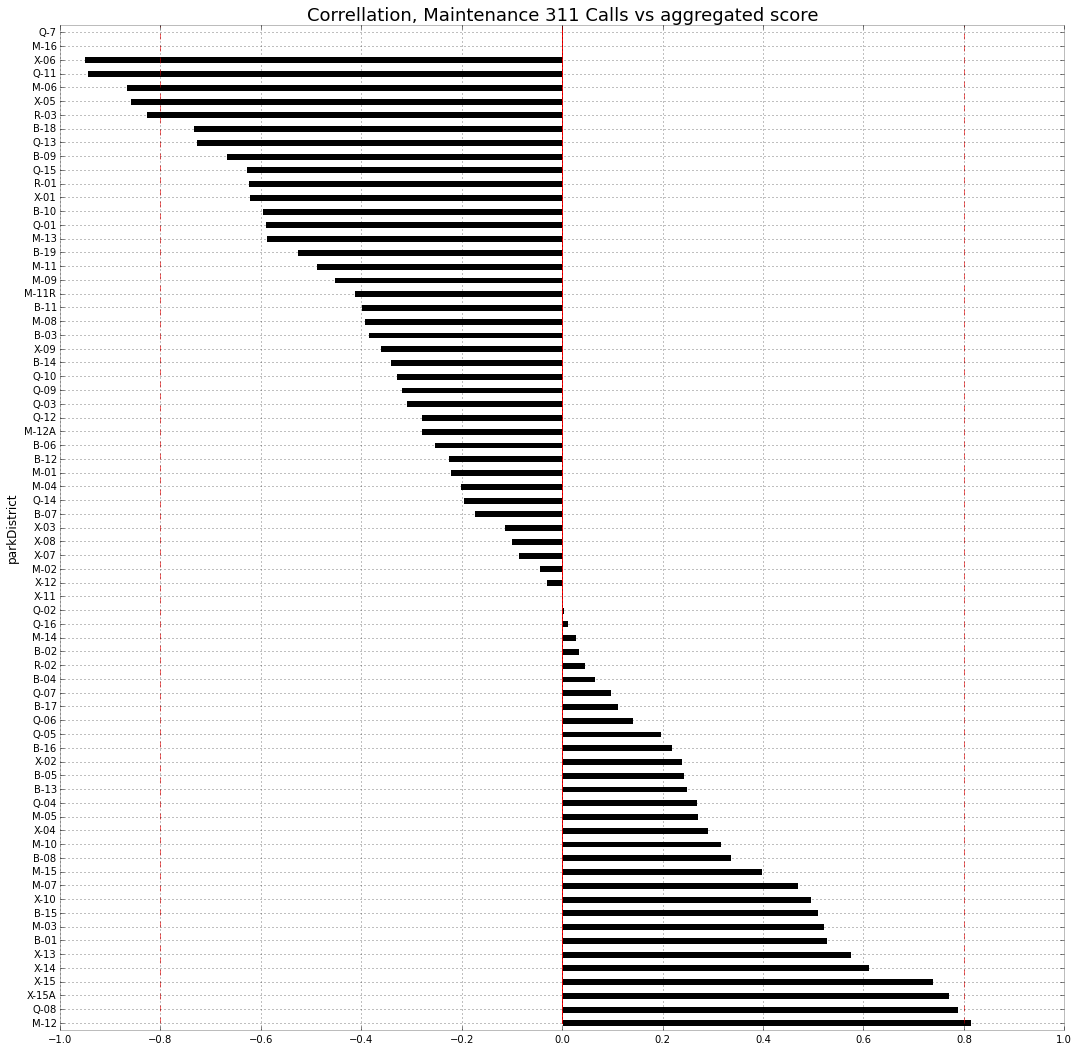

In [48]:
plotCorr(mcorr, title='Correllation, Maintenance 311 Calls vs aggregated score' )

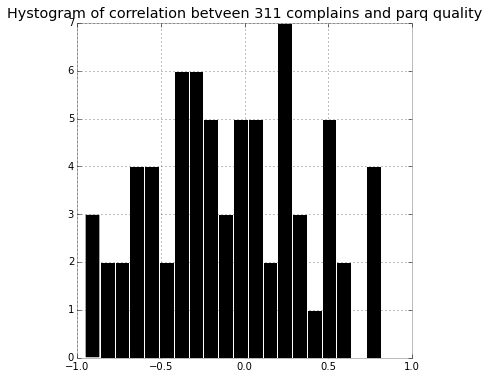

In [50]:
mcorr.hist(color='k',bins=20, figsize=(6,6))
plt.title('Hystogram of correlation betveen 311 complains and parq quality');

In [24]:
mcorr.mean()

-0.0961524983937999

## Cheking only related to Park quality scores

In [55]:
pcalls = pd.read_csv(PARQA + '/parqa/311/TIMESERIES/311_timeseries_precize.csv').set_index('parkDistrict')
Pcalls_n = normalise_timeseries(pcalls)


In [58]:
pcorr = Pcalls_n.corrwith(pip_n, axis=1)

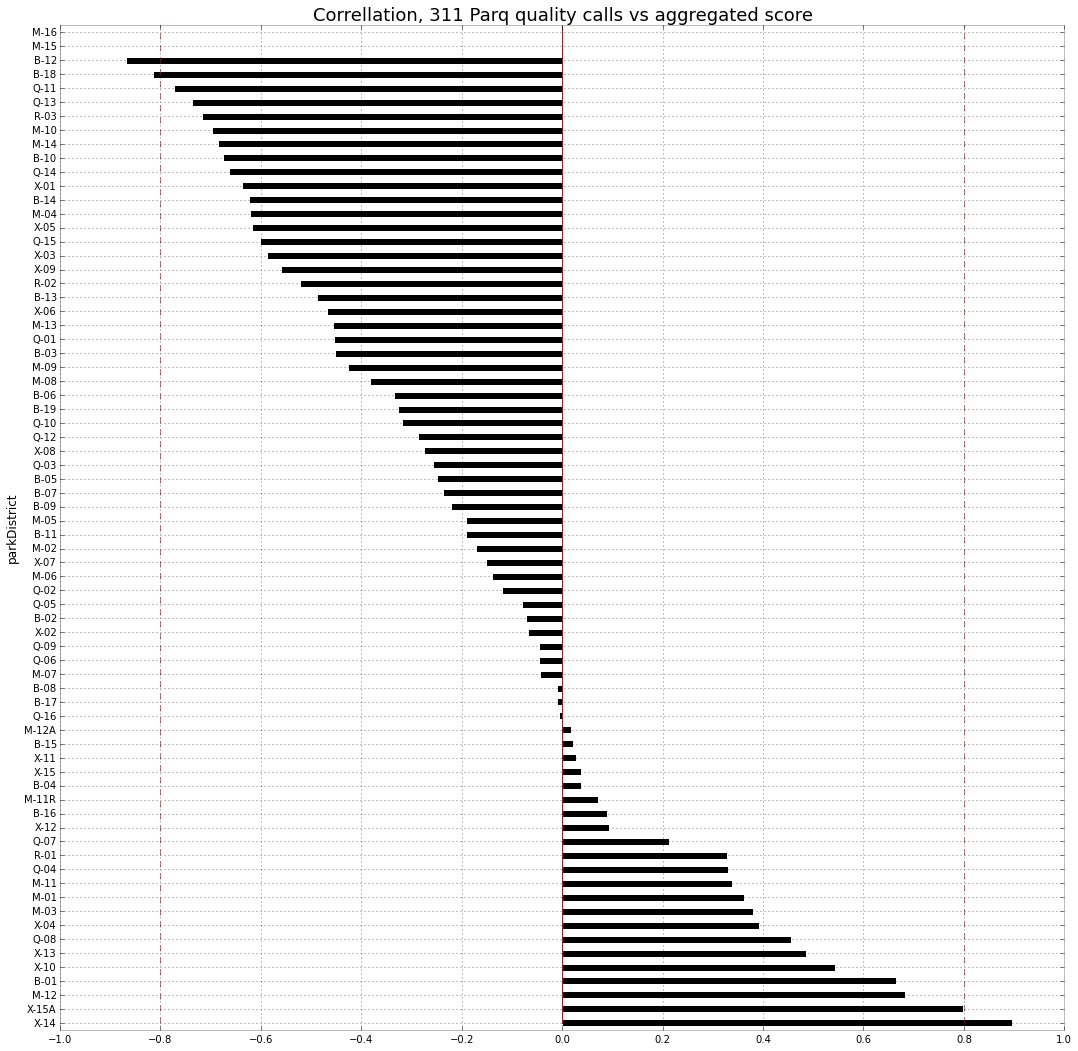

In [59]:
plotCorr(pcorr, title='Correllation, 311 Parq quality calls vs aggregated score' )

In [32]:
pipArea = pipTs[pipTs.score_type == 'Area Normalized Score'][['District']+ [str(x) for x in xrange(2010,2016)]]
pipArea = pipArea.rename(columns={'District':'parkDistrict'}).set_index('parkDistrict')
pipArea = normalise_timeseries(pipArea)

pipNaive = pipTs[pipTs.score_type == 'Naive Normalized Score'][['District']+ [str(x) for x in xrange(2010,2016)]]
pipNaive = pipNaive.rename(columns={'District':'parkDistrict'}).set_index('parkDistrict')
pipArea = normalise_timeseries(pipNaive)

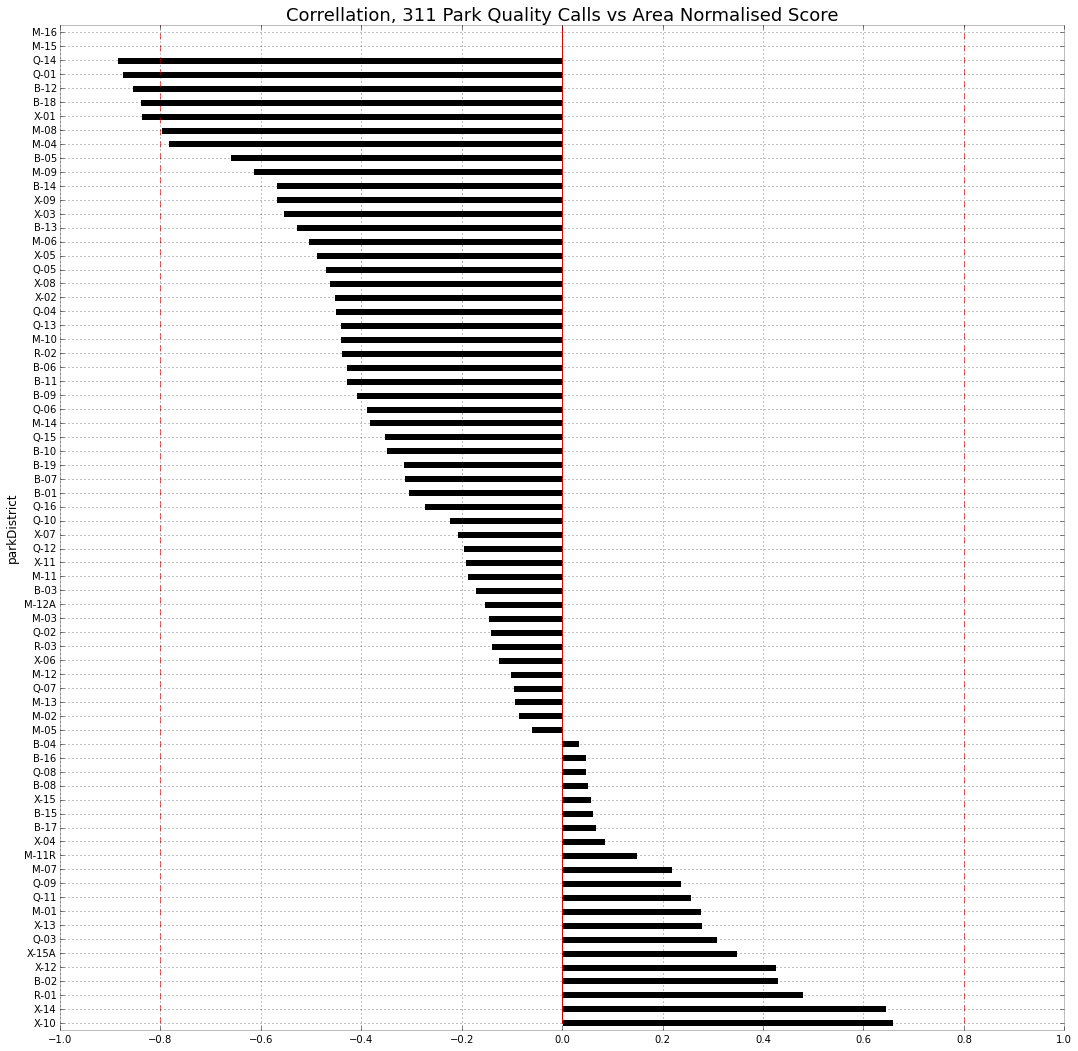

In [62]:
corrA = Pcalls_n.corrwith(pipArea, axis=1)
plotCorr(corrA, title='Correllation, 311 Park Quality Calls vs Area Normalised Score' )

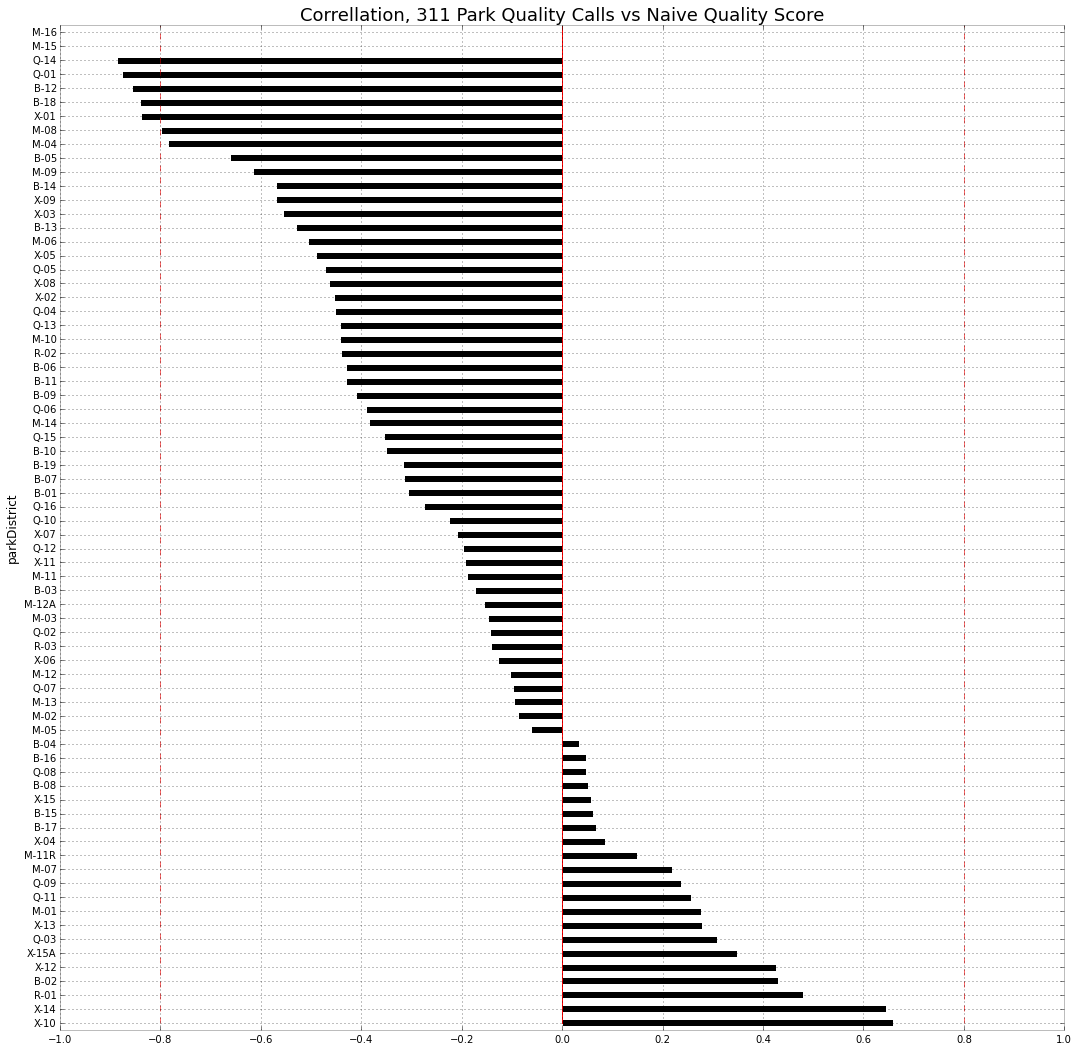

In [69]:
corrN = Pcalls_n.corrwith(pipNaive, axis=1)
plotCorr(corrN, title='Correllation, 311 Park Quality Calls vs Naive Quality Score' )

In [70]:
corrA.describe()

count    70.000000
mean     -0.209983
std       0.375476
min      -0.885703
25%      -0.453381
50%      -0.204202
75%       0.051316
max       0.659572
dtype: float64

In [71]:
corrN.describe()

count    70.000000
mean     -0.209983
std       0.375476
min      -0.885703
25%      -0.453381
50%      -0.204202
75%       0.051316
max       0.659572
dtype: float64

----------------

## Specific scores

In [107]:
pipLitter = pd.read_csv(PARQA + '/parqa/311/TIMESERIES/PIP_score_Litter_timeseries.csv')[['District']+ [str(x) for x in xrange(2010,2016)]]
pipLitter = pipLitter.rename(columns={'District':'parkDistrict'}).set_index('parkDistrict')
pipLitter = normalise_timeseries(pipLitter)

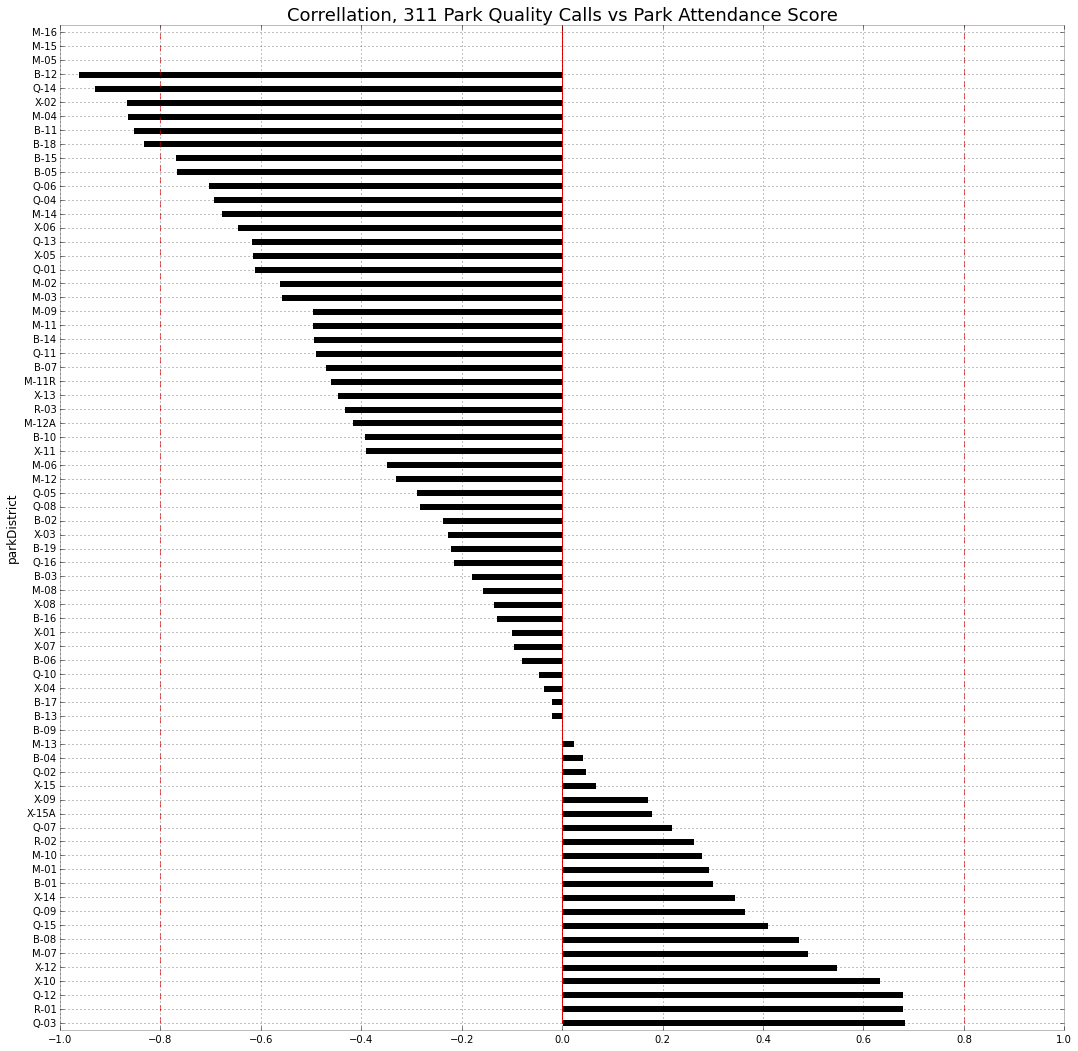

In [114]:
corrPL = Pcalls_n.corrwith(pipLitter, axis=1)
plotCorr(corrPL, title='Correllation, 311 Park Quality Calls vs Park Attendance Score' )

In [115]:
corrPL.describe()

count    69.000000
mean     -0.196814
std       0.442546
min      -0.964166
25%      -0.498431
50%      -0.223150
75%       0.068275
max       0.683054
dtype: float64

## Calls and scores on Litter

In [109]:
callsLitter = pd.read_csv(PARQA + '/parqa/311/TIMESERIES/311_timeseries_litter.csv').set_index('parkDistrict')
callsLitter_n = normalise_timeseries(callsLitter) 

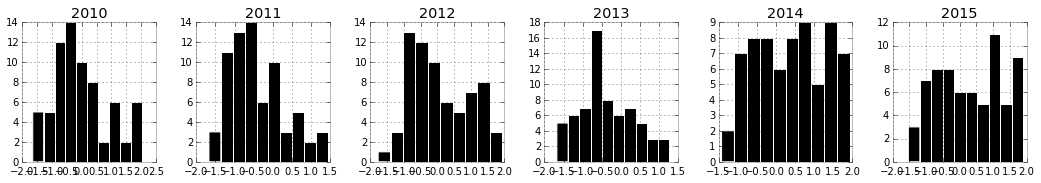

In [110]:
callsLitter.hist(layout=(1,6), color='k', figsize=(18,2.5));

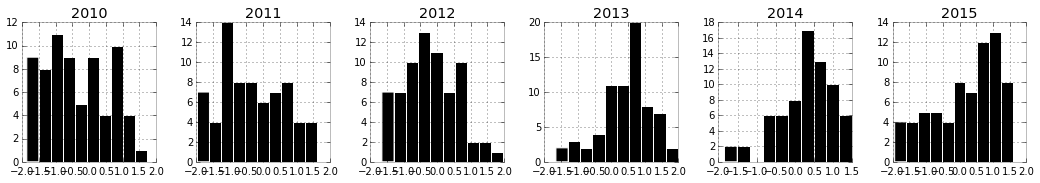

In [111]:
pipLitter.hist(layout=(1,6), color='k', figsize=(18,2.5));

In [112]:
corrLL = callsLitter_n.corrwith(pipLitter, axis=1)
corrLL.describe()

count    69.000000
mean     -0.208202
std       0.419893
min      -0.922059
25%      -0.511149
50%      -0.191503
75%       0.056848
max       0.748345
dtype: float64

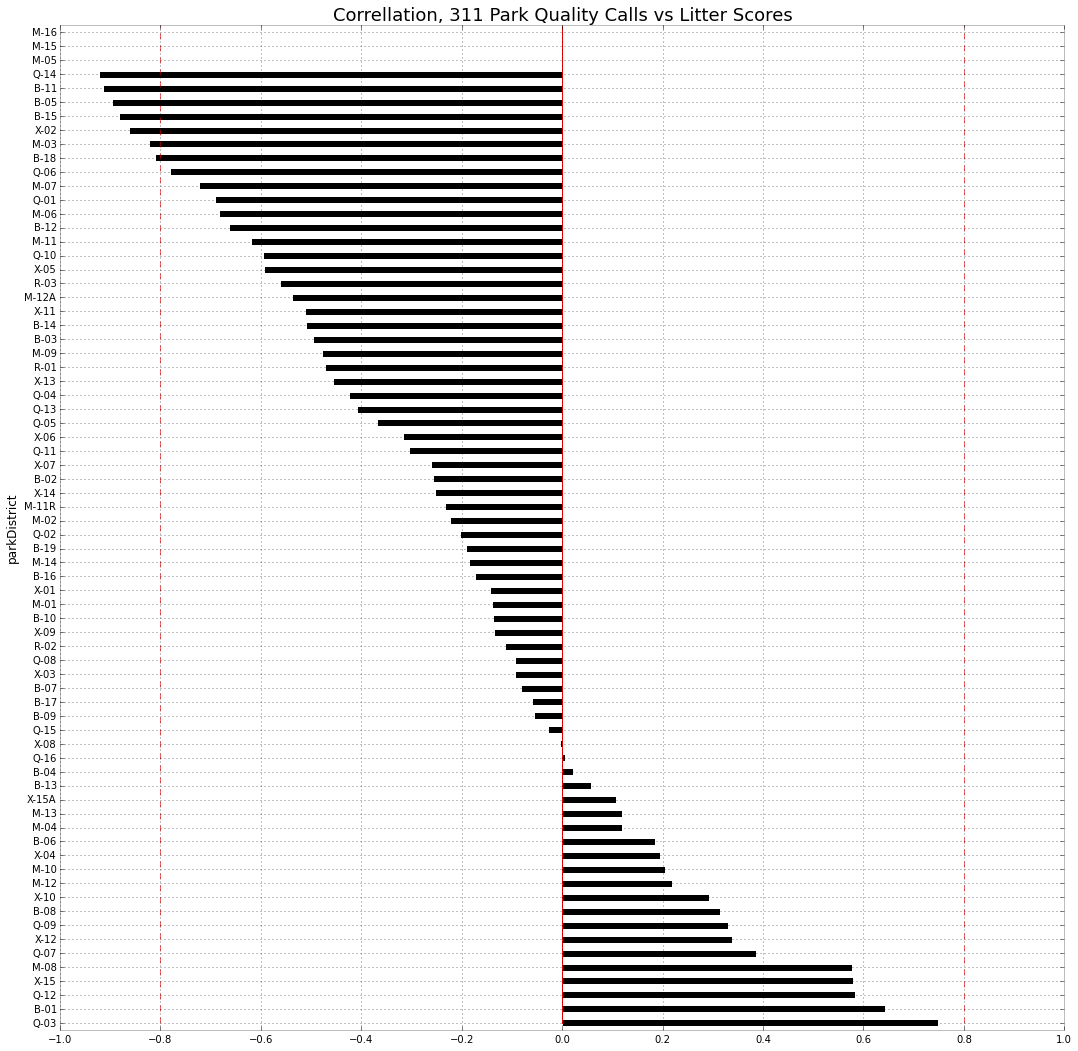

In [113]:
plotCorr(corrLL, title='Correllation, 311 Park Quality Calls vs Litter Scores' )

## Calls and scores on Graphity

In [116]:
callsGraphity = pd.read_csv(PARQA + '/parqa/311/TIMESERIES/311_timeseries_graphity.csv').set_index('parkDistrict')
callsGraphity_n = normalise_timeseries(callsGraphity) 

In [117]:
pipGraphity = pd.read_csv(PARQA + '/parqa/311/TIMESERIES/PIP_score_Graffiti_timeseries.csv')[['District']+ [str(x) for x in xrange(2010,2016)]]
pipGraphity = pipGraphity.rename(columns={'District':'parkDistrict'}).set_index('parkDistrict')
pipGraphity = normalise_timeseries(pipGraphity)

In [119]:
corrGG = callsGraphity_n.corrwith(pipGraphity, axis=1)

In [120]:
corrGG.describe()

count    67.000000
mean     -0.003355
std       0.463565
min      -0.944911
25%      -0.360418
50%      -0.023745
75%       0.317119
max       1.000000
dtype: float64

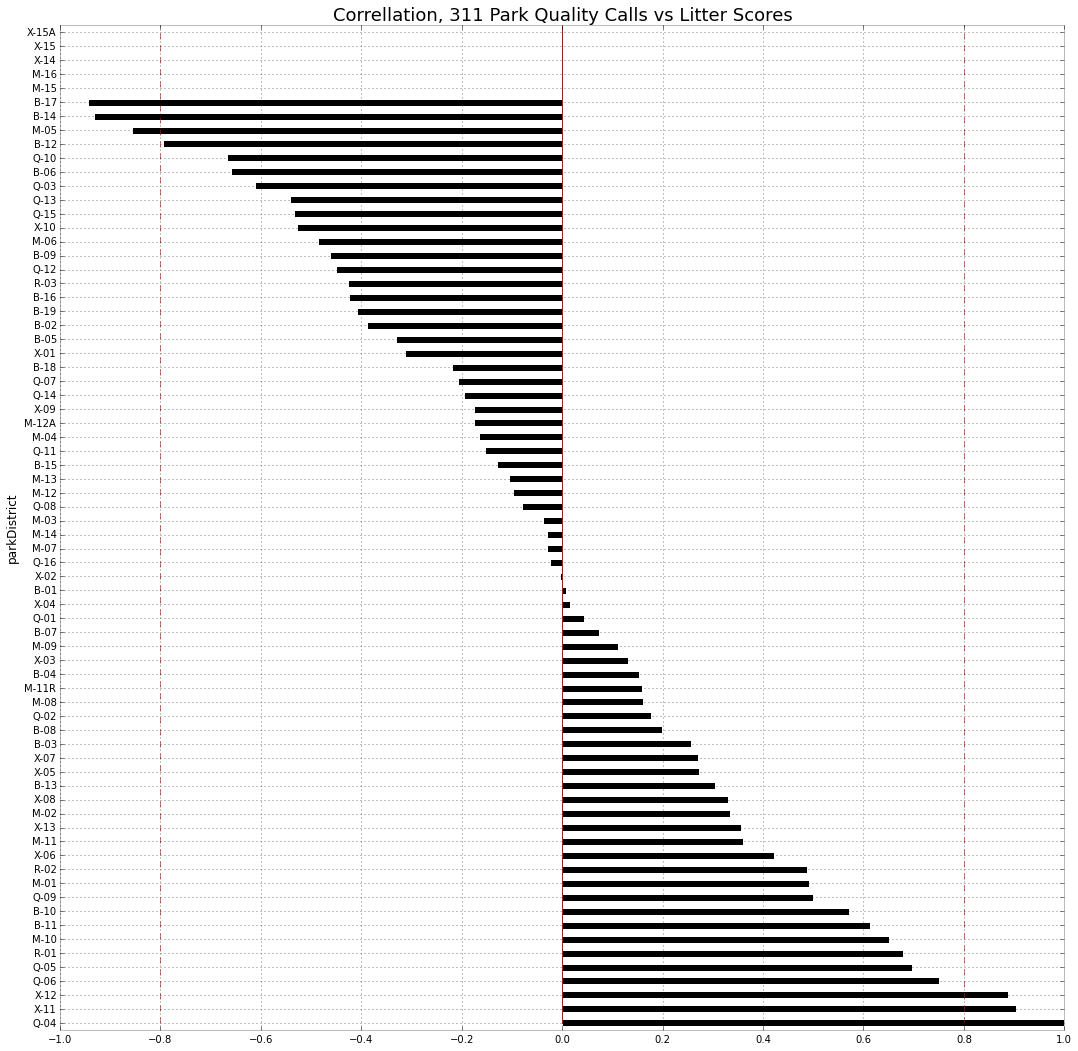

In [121]:
plotCorr(corrGG, title='Correllation, 311 Park Quality Calls vs Litter Scores' )

## Calls and scores on Graphity

In [12]:
pipGlass = pd.read_csv(PARQA + '/parqa/311/TIMESERIES/PIP_score_Glass_timeseries.csv')[['District']+ [str(x) for x in xrange(2010,2016)]]
pipGlass = pipGlass.rename(columns={'District':'parkDistrict'}).set_index('parkDistrict')
pipGlass = normalise_timeseries(pipGlass)

In [14]:
callsGlass_n = normalise_timeseries(pd.read_csv(PARQA + '/parqa/311/TIMESERIES/311_timeseries_glass.csv').set_index('parkDistrict'))

In [15]:
corrGlGl = callsGlass_n.corrwith(pipGlass, axis=1)

In [16]:
corrGlGl.describe()

count    48.000000
mean     -0.075068
std       0.592201
min      -1.000000
25%      -0.571894
50%      -0.159070
75%       0.461761
max       1.000000
dtype: float64

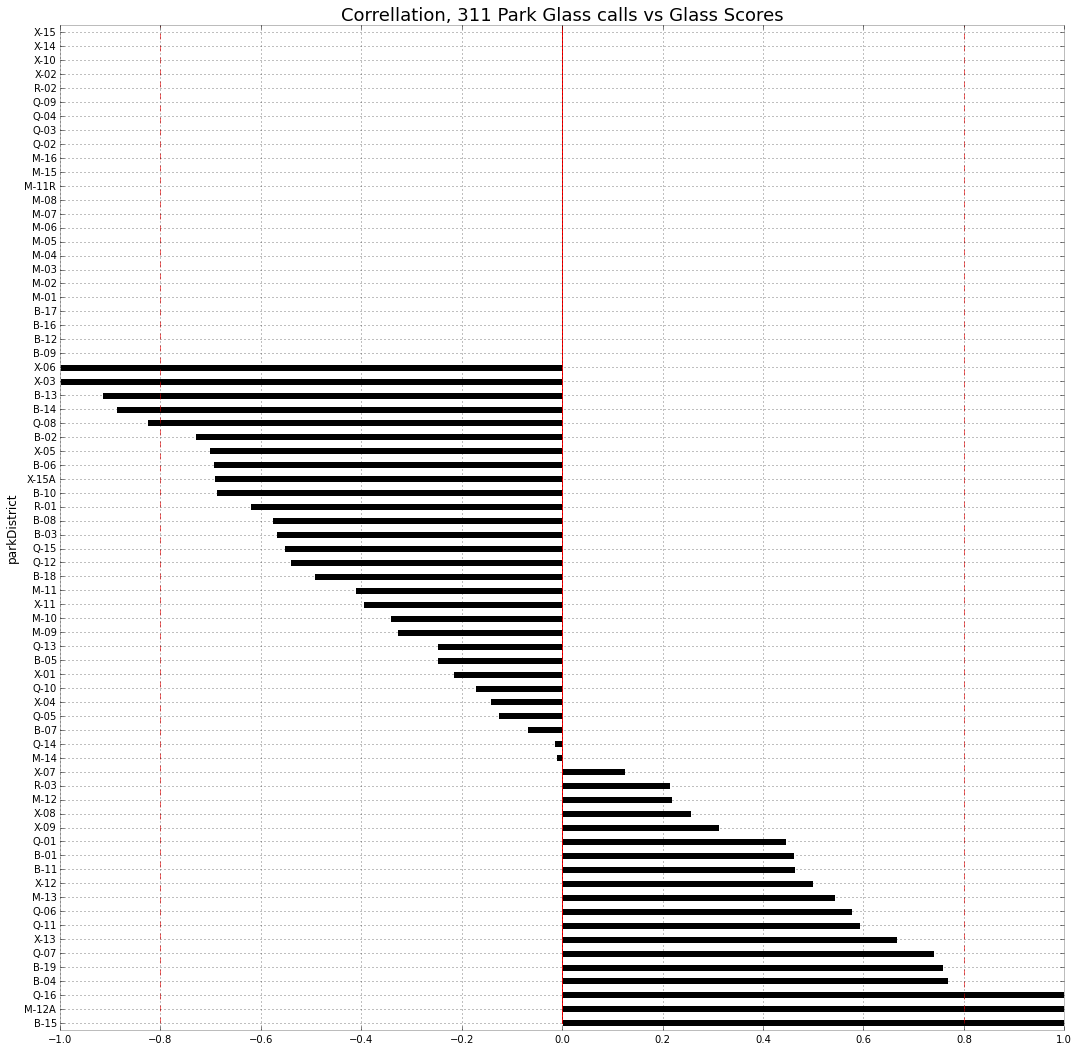

In [19]:
plotCorr(corrGlGl, title='Correllation, 311 Park Glass calls vs Glass Scores' )